# Fusion

In [91]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from config import *
from common import *
display.clear_output()

## 1. Setup Environments

In [93]:
from affwild2_challenge.basic_emotion.losses1 import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion.metrics import expr_score, f1_score, concordance_cc2

from affwild2_challenge.basic_emotion.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name

In [124]:
params = {}
params["results_dir"]   = os.path.join(sub_dir, "results", "t26")
params["db_file"]       = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_aligned_frames.h5")
params["db_root"]       = os.path.join(dataset_dir, "AffWild2/data/cropped_aligned")

params["db_file_1"]       = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_frames.h5")
params["db_root_1"]       = os.path.join(dataset_dir, "AffWild2/data/cropped")

params["valid_files"]   = [os.path.join(sub_dir, "results", "t11", "valid_32.npz"), # cropped_aligned emotion
                           os.path.join(sub_dir, "results", "t22", "valid_16.npz"), # cropped_aligned emotion_va
                           os.path.join(sub_dir, "results", "t24", "valid.npz")]    # cropped emotion

params["test_files"]   = [os.path.join(sub_dir, "results", "t11", "test_32.npz"), 
                           os.path.join(sub_dir, "results", "t22", "test_16.npz"), 
                           os.path.join(sub_dir, "results", "t24", "test_1.npz")]


# params["test_va_files"]   = [os.path.join(sub_dir, "results", "t1", "test_va.npz"), 
#                            os.path.join(sub_dir, "results", "t16", "test_va_32.npz"), 
#                            os.path.join(sub_dir, "results", "t22", "test_va_16.npz")]

params["scheme"]        = "emotion"

print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

parameters: 
+ results_dir: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t26
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
+ db_file_1: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames.h5
+ db_root_1: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
+ valid_files: ['/home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t11/valid_32.npz', '/home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t22/valid_16.npz', '/home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t24/valid.npz']
+ test_files: ['/home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t11/test_32.npz', '/home/pc/Documents/dntai/projects/Emotion/AffWild2Prj

## 2. Setup Data

In [125]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)

# Dataset Configuration
dataset_info_1  = dict(db_file = params["db_file_1"], db_root = params["db_root_1"])
print("dataset_info_1: ")
for key in dataset_info_1.keys(): print("+ %s: %s"%(key,dataset_info_1[key]))
    
ds1 = AffWild2Dataset(**dataset_info_1)

dataset_info: 
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
dataset_info_1: 
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped


In [126]:
ds.load_scheme_emotion_va()
idx2 = ds.a_idx_valid

ds.load_scheme_emotion()
idx1 = ds.a_idx_valid

ds1.load_scheme_emotion()
idx3 = ds.a_idx_valid

Loading Scheme Emotion VA: 
 + Loading train: 194
 + Loading valid: 57
 + Loading test: 223
 + Loading va_test: 139
Loading Scheme Emotion: 
 + Loading train: 251
 + Loading valid: 69
 + Loading test: 223
Loading Scheme Emotion: 
 + Loading train: 251
 + Loading valid: 69
 + Loading test: 223


In [127]:
idx_all = np.arange(len(ds.df_frames))

filter_union = np.zeros(len(ds.df_frames), np.int)
filter_union[idx1] = filter_union[idx1] + 1
filter_union[idx2] = filter_union[idx2] + 1
filter_union[idx3] = filter_union[idx3] + 1

idx_union = idx_all[filter_union==3]

dict_idx1 = dict(zip(idx1, range(len(idx1))))
dict_idx2 = dict(zip(idx2, range(len(idx2))))
dict_idx3 = dict(zip(idx3, range(len(idx3))))

mapping_idx1 = [dict_idx1[i] for i in idx_union]
mapping_idx2 = [dict_idx2[i] for i in idx_union]
mapping_idx3 = [dict_idx3[i] for i in idx_union]

In [128]:
def avg_fusion_v1(save_dir, save_name, fusion_files, has_va = True, a_idx_mapping = None):
    y_pred_fusion_emotion = []
    y_pred_fusion_aro     = []
    y_pred_fusion_val     = []
    y_fusion_results      = {}
    for load_path, idx_mapping in zip(fusion_files, a_idx_mapping):
        y_results = dict(np.load(load_path, allow_pickle=True))
        y_pred_emotion = y_results["emotion"][idx_mapping]
        print(y_pred_emotion.shape)
        y_pred_fusion_emotion.append(y_pred_emotion)
        
        if has_va == True:
            y_pred_aro     = y_results["aro_ccc"][idx_mapping].flatten()
            y_pred_fusion_aro.append(y_pred_aro)

            y_pred_val     = y_results["val_ccc"][idx_mapping].flatten()
            y_pred_fusion_val.append(y_pred_val)
        # if
    # for
    
    y_pred_fusion_emotion = np.array(y_pred_fusion_emotion)
    y_pred_fusion_emotion = np.average(y_pred_fusion_emotion, axis = 0)
    y_fusion_results["emotion"] = y_pred_fusion_emotion
    
    if has_va == True:
        y_pred_fusion_aro     = np.array(y_pred_fusion_aro)
        y_pred_fusion_aro     = np.average(y_pred_fusion_aro, axis = 0)
        y_fusion_results["aro_ccc"] = y_pred_fusion_aro

        y_pred_fusion_val     = np.array(y_pred_fusion_val)
        y_pred_fusion_val     = np.average(y_pred_fusion_val, axis = 0)
        y_fusion_results["val_ccc"] = y_pred_fusion_val
    # if
    
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_name)
    np.savez(save_path, **y_fusion_results)
    
    return y_fusion_results
# avg_fusion

def avg_fusion(save_dir, save_name, fusion_files, has_va = True):
    y_pred_fusion_emotion = []
    y_pred_fusion_aro     = []
    y_pred_fusion_val     = []
    y_fusion_results      = {}
    for load_path in fusion_files:
        y_results = dict(np.load(load_path, allow_pickle=True))
        y_pred_emotion = y_results["emotion"]
        print(y_pred_emotion.shape)
        y_pred_fusion_emotion.append(y_pred_emotion)
        
        if has_va == True:
            y_pred_aro     = y_results["aro_ccc"].flatten()
            y_pred_fusion_aro.append(y_pred_aro)

            y_pred_val     = y_results["val_ccc"].flatten()
            y_pred_fusion_val.append(y_pred_val)
        # if
    # for
    
    y_pred_fusion_emotion = np.array(y_pred_fusion_emotion)
    y_pred_fusion_emotion = np.average(y_pred_fusion_emotion, axis = 0)
    y_fusion_results["emotion"] = y_pred_fusion_emotion
    
    if has_va == True:
        y_pred_fusion_aro     = np.array(y_pred_fusion_aro)
        y_pred_fusion_aro     = np.average(y_pred_fusion_aro, axis = 0)
        y_fusion_results["aro_ccc"] = y_pred_fusion_aro

        y_pred_fusion_val     = np.array(y_pred_fusion_val)
        y_pred_fusion_val     = np.average(y_pred_fusion_val, axis = 0)
        y_fusion_results["val_ccc"] = y_pred_fusion_val
    # if
    
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_name)
    np.savez(save_path, **y_fusion_results)
    
    return y_fusion_results
# avg_fusion

def view_summary(load_name, load_type, load_dir, scheme_name, a_idx_data, ds):
    load_path = os.path.join(load_dir, load_name)
    
    print("================================")
    print(f"Summary [{load_type}]")
    print(f"+ File: {load_path}")
    print(f"+ Scheme: {scheme_name}")
    print(f"+ Nummber of items: {len(a_idx_data)}")
    print("================================")

    
    y_results            = dict(np.load(load_path, allow_pickle=True))
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values

    print(f"Nummber of frames: {len(y_pred_emotion_label)}")

    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)

    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")

    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)

    if scheme_name=="emotion_va":
        aro_pred = y_results["aro_ccc"].flatten()
        val_pred = y_results["val_ccc"].flatten()
        aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
        val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

        aro_ccc1 = concordance_cc2(aro_true, aro_pred)
        aro_ccc2 = ccc_numpy(aro_true, aro_pred)
        val_ccc1 = concordance_cc2(val_true, val_pred)
        val_ccc2 = ccc_numpy(val_true, val_pred)

        avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
        avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

        print(f"aro: {aro_ccc1}, {aro_ccc2}")
        print(f"val: {val_ccc1}, {val_ccc2}")
        print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
    # if
# view_summary

## Valid

(254674, 7)
(254674, 7)
(254674, 7)
Summary [valid]
+ File: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t26/valid.npz
+ Scheme: emotion
+ Nummber of items: 254674
Nummber of frames: 254674
Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.84      0.49      0.61    156207
       Angry       0.11      0.25      0.15      6736
     Disgust       0.05      0.19      0.08       986
        Fear       0.11      0.14      0.12      8197
       Happy       0.41      0.76      0.54     36120
         Sad       0.52      0.54      0.53     30537
    Surprise       0.27      0.60      0.37     15891

    accuracy                           0.52    254674
   macro avg       0.33      0.42      0.34    254674
weighted avg       0.66      0.52      0.55    254674

Confustion Matrix Int: 
 [[75924 11294  1850  5749 32362  9037 19991]
 [  757  1708    63   458  1402  1701   647]
 [   67   137   183    11   273   180   135]
 [ 2

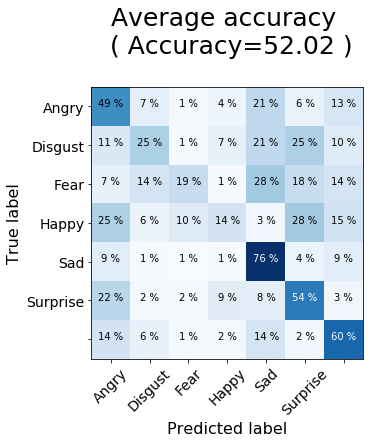

In [129]:
y_valid_fusion_results = avg_fusion_v1(save_dir=params["results_dir"], 
                                    save_name="valid.npz", 
                                    fusion_files = params["valid_files"], 
                                    has_va = False,
                                    a_idx_mapping = [mapping_idx1, mapping_idx2, mapping_idx3])

view_summary(load_name   = "valid.npz", 
             load_type   = "valid", 
             load_dir    = params["results_dir"], 
             scheme_name = params["scheme"], 
             a_idx_data  = idx_union, 
             ds          = ds)

## Test & TestVA

In [130]:
y_test_fusion_results = avg_fusion(save_dir=params["results_dir"], 
                                    save_name="test.npz", 
                                    fusion_files = params["test_files"], 
                                    has_va = False)

# y_va_test_fusion_results = avg_fusion(save_dir=params["results_dir"], 
#                                     save_name="test_va.npz", 
#                                     fusion_files = params["test_va_files"], 
#                                     has_va = True)

(997332, 7)
(997332, 7)
(997332, 7)
